In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [22]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32





DIRECTORY = r"C:\Users\jatin\Desktop\datascience2\projectssssssss\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]


data = []
labels = []
print("[INFO] loading images...")

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)




[INFO] loading images...


C:\Users\jatin\anaconda3\New folder\envs\tensorflow\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [24]:
data


[array([[[-0.46666664, -0.49019605, -0.4352941 ],
         [-0.46666664, -0.49019605, -0.4352941 ],
         [-0.46666664, -0.49019605, -0.4352941 ],
         ...,
         [-0.38823527, -0.6392157 , -0.7411765 ],
         [-0.38823527, -0.6392157 , -0.7411765 ],
         [-0.38823527, -0.6392157 , -0.7411765 ]],
 
        [[-0.46666664, -0.49019605, -0.4352941 ],
         [-0.46666664, -0.49019605, -0.4352941 ],
         [-0.46666664, -0.49019605, -0.4352941 ],
         ...,
         [-0.38823527, -0.6392157 , -0.7411765 ],
         [-0.38823527, -0.6392157 , -0.7411765 ],
         [-0.38823527, -0.6392157 , -0.7411765 ]],
 
        [[-0.3960784 , -0.4588235 , -0.372549  ],
         [-0.3960784 , -0.4588235 , -0.372549  ],
         [-0.3960784 , -0.4588235 , -0.372549  ],
         ...,
         [-0.45098037, -0.62352943, -0.8039216 ],
         [-0.45098037, -0.62352943, -0.8039216 ],
         [-0.45098037, -0.62352943, -0.8039216 ]],
 
        ...,
 
        [[-0.4352941 , -0.6862745 

In [25]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [27]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [31]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [40]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [41]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [42]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [43]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [44]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 95 steps, validate on 767 samples
Epoch 1/20
95/95 [==============================] - 193s 2s/step - loss: 0.5575 - accuracy: 0.7307 - val_loss: 0.4382 - val_accuracy: 0.8057
Epoch 2/20
95/95 [==============================] - 157s 2s/step - loss: 0.3073 - accuracy: 0.8731 - val_loss: 0.3633 - val_accuracy: 0.8451
Epoch 3/20
95/95 [==============================] - 158s 2s/step - loss: 0.2248 - accuracy: 0.9094 - val_loss: 0.3404 - val_accuracy: 0.8628
Epoch 4/20
95/95 [==============================] - 155s 2s/step - loss: 0.1888 - accuracy: 0.9305 - val_loss: 0.2671 - val_accuracy: 0.8845
Epoch 5/20
95/95 [==============================] - 165s 2s/step - loss: 0.1762 - accuracy: 0.9374 - val_loss: 0.4155 - val_accuracy: 0.8533
Epoch 6/20
95/95 [==============================] - 173s 2s/step - loss: 0.1541 - accuracy: 0.9397 - val_loss: 0.3354 - val_accuracy: 0.8709
Epoch 7/20
95/95 [==============================] - 176s 2s/s

In [46]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model",encoding='utf-8', save_format="h5")


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.80      0.88       383
without_mask       0.83      0.99      0.90       384

    accuracy                           0.89       767
   macro avg       0.91      0.89      0.89       767
weighted avg       0.91      0.89      0.89       767

[INFO] saving mask detector model...


TypeError: save() got an unexpected keyword argument 'encoding'

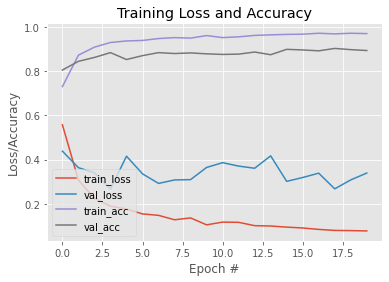

In [47]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")